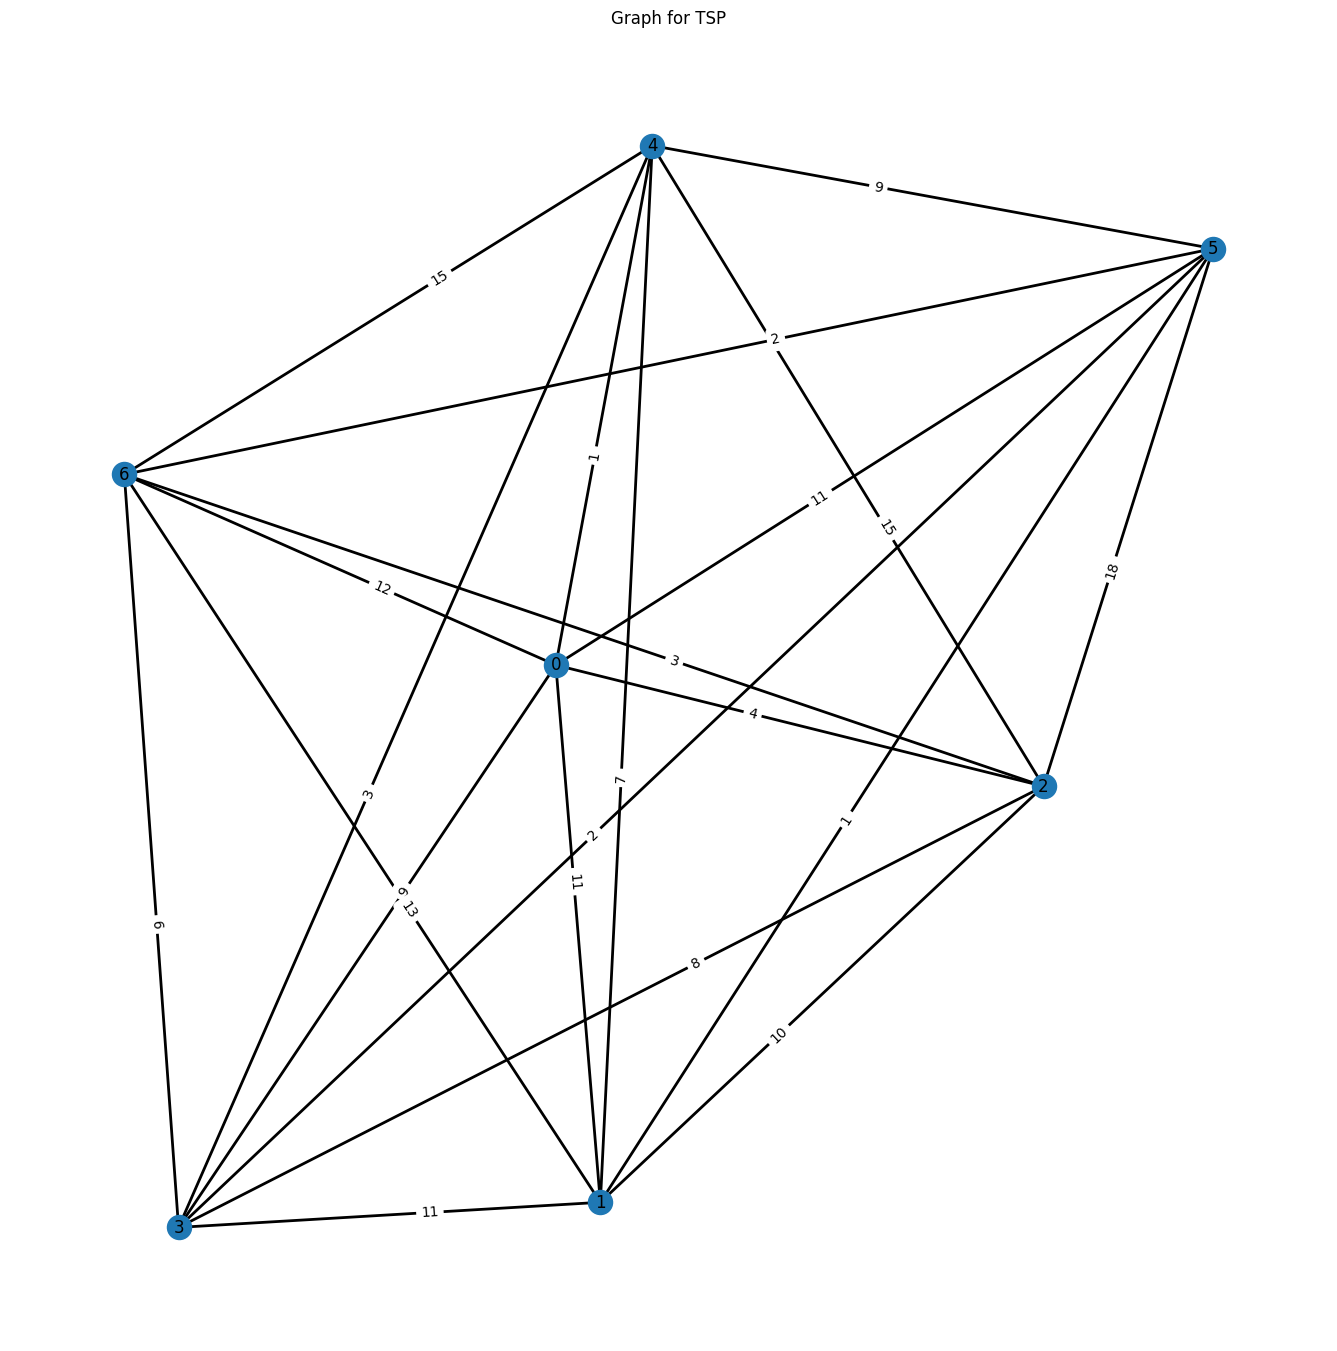

[np.int64(5), 1, 4, 0, 2, 6, 3]
[np.int64(3), 5, 1, 4, 0, 2, 6, np.int64(3)]
[3, 4, 0, 2, 6, 5, 1]
[0, 2, 6, 5, 1, 3, 4, 0]


ValueError: a must be 1-dimensional

In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from itertools import combinations
from collections import defaultdict

def generate_random_weighted_graph(n, low, high):
    g = nx.generators.complete_graph(n)
    g.add_weighted_edges_from([(a, b, np.random.randint(low, high)) for a, b in g.edges()])
    nx.set_node_attributes(g, nx.spring_layout(g), "pos")
    return g

def plot_graph(g, title="", highlight_edges=[]):
    pos = nx.get_node_attributes(g, "pos")
    plt.figure(figsize=(17, 17))
    plt.title(title)
    nx.draw(g, pos=pos, labels={x: x for x in g.nodes}, width=2)
    weights = nx.get_edge_attributes(g, "weight")
    nx.draw_networkx_edge_labels(g, pos, edge_labels=weights, label_pos=.4)
    nx.draw_networkx_edges(g, pos, edgelist=highlight_edges, edge_color="r", width=3)
    nx.draw_networkx_edge_labels(
        g, pos,
        edge_labels={
            e: w
            for e, w in weights.items()
            if e in map(lambda x: tuple(sorted(x)), highlight_edges)
        },
        font_color="r",
        label_pos=.4
    )
    plt.show()

np.random.seed(3)
g = generate_random_weighted_graph(7, 1, 20)
plot_graph(g, "Graph for TSP")

def nearest_neighbour_initialization(g, closed_tour=False):
    curr_node = np.random.choice(g.nodes)
    path = [curr_node]
    not_visited = set(g.nodes) - {curr_node}
    while not_visited:
        not_visited_neighbours = not_visited & set(g.neighbors(curr_node))
        key = lambda x: g[curr_node][x]["weight"]
        curr_node = min(not_visited_neighbours, key=key)
        path.append(curr_node)
        not_visited.remove(curr_node)
    if closed_tour:
        path.append(path[0])
    return path

np.random.seed(1)
print(nearest_neighbour_initialization(g))
print(nearest_neighbour_initialization(g, closed_tour=True))

def has_cycle(g):
    try:
        nx.find_cycle(g)
    except nx.NetworkXNoCycle:
        return False
    return True

def get_path_from_edges(edges, closed_tour=False):
    path_graph = nx.Graph(edges)
    curr = min(path_graph.nodes, key=path_graph.degree)
    path, visited = [curr], {curr}
    while len(path) < len(path_graph):
        curr = (set(path_graph.neighbors(curr)) - visited).pop()
        visited.add(curr)
        path.append(curr)
    if closed_tour:
        path.append(path[0])
    return path

def shortest_edge_initialization(g, closed_tour=False):
    edge_list = set(g.edges)
    times_visited = defaultdict(int)
    tour = set()
    max_tour_len = len(g) if closed_tour else len(g) - 1
    key = nx.get_edge_attributes(g, "weight").get
    while len(tour) < max_tour_len:
        u, v = min(edge_list, key=key)
        times_visited[u] += 1
        times_visited[v] += 1
        tour.add((u, v))
        edge_list.remove((u, v))
        for u, v in set(edge_list):
            if (
                (has_cycle(nx.Graph(tour | {(u, v)})) and len(tour) != len(g) - 1)
                or times_visited[u] == 2 or times_visited[v] == 2
            ):
                edge_list.remove((u, v))
    return get_path_from_edges(tour, closed_tour=closed_tour)

np.random.seed(1)
print(shortest_edge_initialization(g))
print(shortest_edge_initialization(g, closed_tour=True))

def make_valid_tour(p, nodes):
    unvisited = set(nodes) - set(p)
    indices = defaultdict(list)
    for i in range(len(p)):
        indices[p[i]].append(i)
    visited_twice = {node for node in indices if len(indices[node]) == 2}
    for node in visited_twice:
        change_index = np.random.choice(indices[node])
        p[change_index] = unvisited.pop()
    return p

def partially_matched_crossover(p1, p2):
    pt = np.random.randint(1, len(p1) - 1)
    c1 = p1[:pt] + p2[pt:]
    c2 = p2[:pt] + p1[pt:]
    nodes = set(p1)
    return make_valid_tour(c1, nodes), make_valid_tour(c2, nodes)

def path_length(path):
    return sum(g[path[i]][path[i + 1]]["weight"] for i in range(len(path) - 1))

def roulette_wheel_selection(fitness_func, population):
    fitness_values = [1 / fitness_func(p) for p in population]
    total_fitness = sum(fitness_values)
    probabilities = [f / total_fitness for f in fitness_values]
    selected = np.random.choice(population, size=len(population), p=probabilities, replace=True)
    return selected.tolist()

np.random.seed(2)
n_population = 8
population = [shortest_edge_initialization(g, closed_tour=False) for _ in range(n_population)]
selected_population = roulette_wheel_selection(path_length, population)
parents = selected_population[:2]
print(parents)
print(partially_matched_crossover(*parents))

def order_crossover(p1, p2):
    start = np.random.randint(0, len(p1) - 1)
    end = np.random.randint(start + 1, len(p1) if start != 0 else len(p1) - 1)
    
    def fill_blanks(parent1, parent2, s, e):
        unvisited_nodes = parent2.copy()
        for node in parent1[s:e]:
            unvisited_nodes.remove(node)
        child = parent1.copy()
        for i in range(len(parent1)):
            if i < s or i >= e:
                child[i] = unvisited_nodes.pop(0)
        return child
    
    c1 = fill_blanks(p1, p2, start, end)
    c2 = fill_blanks(p2, p1, start, end)
    return c1, c2

def inv_path_length(path):
    return 1 / path_length(path)

np.random.seed(2)
n_population = 8
population = [shortest_edge_initialization(g, closed_tour=False) for _ in range(n_population)]
selected_population = roulette_wheel_selection(inv_path_length, population)
parents = selected_population[:2]
print(parents)
print(order_crossover(*parents))

def inversion_mutation(p):
    start = np.random.randint(0, len(p) - 1)
    end = np.random.randint(start + 1, len(p) + 1)
    subtour = p[start:end]
    c = p.copy()
    for i in range(start, end):
        c[i] = subtour.pop()
    return c

np.random.seed(3)
n_population = 8
population = [shortest_edge_initialization(g, closed_tour=False) for _ in range(n_population)]
subject = population[0]
print(subject, inversion_mutation(subject))

def insertion_mutation(p):
    i = np.random.randint(1, len(p))
    k = np.random.randint(0, len(p) - 1)
    c = p.copy()
    c.insert(k, c.pop(i))
    return c

n_population = 8
population = [shortest_edge_initialization(g, closed_tour=False) for _ in range(n_population)]
subject = population[0]
print(subject, insertion_mutation(subject))